In [1]:
import numpy as np
import pandas as pd

from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, column_or_1d
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from tscv import GapKFold

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

Add precip_depth to model

In [2]:
filepath = '../../../data/intermediate/experimentation_train_sets/'

filename = 'train_b_1176_m_1_sm_n_t_20200204_174703.csv'

df_features = pd.read_csv(filepath + filename, parse_dates=['timestamp'], index_col=['timestamp'])
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8655 entries, 2016-01-02 00:00:00 to 2016-12-31 23:00:00
Data columns (total 9 columns):
day_of_week                 8655 non-null int64
day_hour                    8655 non-null int64
dew_temperature_ma_24H      8655 non-null float64
dew_temperature             8655 non-null float64
air_temperature_ma_24H      8655 non-null float64
air_temperature             8655 non-null float64
precip_depth_1_hr_ma_24H    8655 non-null float64
precip_depth_1_hr_ma_4H     8655 non-null float64
meter_reading               8655 non-null float64
dtypes: float64(7), int64(2)
memory usage: 676.2 KB


In [3]:
df_features.head()

,day_of_week,day_hour,dew_temperature_ma_24H,dew_temperature,air_temperature_ma_24H,air_temperature,precip_depth_1_hr_ma_24H,precip_depth_1_hr_ma_4H,meter_reading
timestamp,,,,,,,,,
2016-01-02 00:00:00,5,0,-10.120833,-8.3,-6.020833,-3.3,-0.208333,0.0,10.3292
2016-01-02 01:00:00,5,1,-9.979167,-8.3,-5.837500,-3.9,-0.166667,0.0,10.3292
2016-01-02 02:00:00,5,2,-9.887500,-8.9,-5.720833,-5.0,-0.125000,0.0,9.8294
2016-01-02 03:00:00,5,3,-9.816667,-9.4,-5.629167,-5.6,-0.083333,0.0,9.6628
2016-01-02 04:00:00,5,4,-9.766667,-9.4,-5.583333,-6.1,-0.083333,0.0,9.1630


In [4]:
target_variables = set(['meter_reading'])
features_variables = set(df_features.columns.to_list())-target_variables
time_variables = set(['day_hour', 'day_of_week'])
meteorological_variables = features_variables - time_variables

print(target_variables)
print(features_variables)
print(time_variables)
print(meteorological_variables)

{'meter_reading'}
{'day_of_week', 'dew_temperature_ma_24H', 'day_hour', 'dew_temperature', 'precip_depth_1_hr_ma_4H', 'air_temperature', 'air_temperature_ma_24H', 'precip_depth_1_hr_ma_24H'}
{'day_of_week', 'day_hour'}
{'dew_temperature_ma_24H', 'dew_temperature', 'precip_depth_1_hr_ma_4H', 'air_temperature', 'air_temperature_ma_24H', 'precip_depth_1_hr_ma_24H'}


In [5]:
#y_meter_trend = df_features['meter_reading']
#y_meter_seasonal = df_features['meter_reading_seasonal']
#y_meter_deseasoned = df_features['meter_reading_deseasoned']
Ys_meter = df_features[target_variables]

X_meter = df_features.loc[:, features_variables]
#X_meter_with_day_hour = df_features.loc[:, meteorological_variables.union(set(['day_hour']))]
print('X_meter.shape = {}, Ys_meter.shape = {}'.format(X_meter.shape, Ys_meter.shape))

X_meter.shape = (8655, 8), Ys_meter.shape = (8655, 1)


In [6]:
X_meter.columns

Index(['day_of_week', 'dew_temperature_ma_24H', 'day_hour', 'dew_temperature',
       'precip_depth_1_hr_ma_4H', 'air_temperature', 'air_temperature_ma_24H',
       'precip_depth_1_hr_ma_24H'],
      dtype='object')

In [7]:
# GapKFold
# gap ~ two weeks, train = 1 month (12 folds)

gap = 24*7*2
gap_kf = GapKFold(n_splits=12, gap_before=gap, gap_after=gap)

<b>Re-build random forest benchmark model</b><br>
<br>
best_params : {'randomforestregressor__max_depth': 7, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 90}<br>
best_score : -0.32601680044996784<br>

In [19]:
X_meter_benchmark = X_meter.copy()
X_meter_benchmark.drop(['precip_depth_1_hr_ma_24H', 'precip_depth_1_hr_ma_4H'], axis=1, inplace=True)

benchmarkRFR = RandomForestRegressor(max_depth=7, max_features='auto', n_estimators=90)

pipe = make_pipeline(benchmarkRFR)

cross_val_score(
    estimator=benchmarkRFR,
    X=X_meter_benchmark,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.3299123755247286

In [20]:
benchmark_preds = cross_val_predict(
    estimator=benchmarkRFR,
    X=X_meter_benchmark,
    y=Ys_meter['meter_reading'],
    cv=gap_kf
)

preds_df = pd.DataFrame(index=X_meter.index)
preds_df['target'] = Ys_meter['meter_reading']
preds_df['benchmark_preds'] = benchmark_preds

preds_df_melt = pd.melt(
    preds_df.reset_index(inplace=False),
    id_vars='timestamp', 
    var_name='component', 
    value_name = 'reading'
)

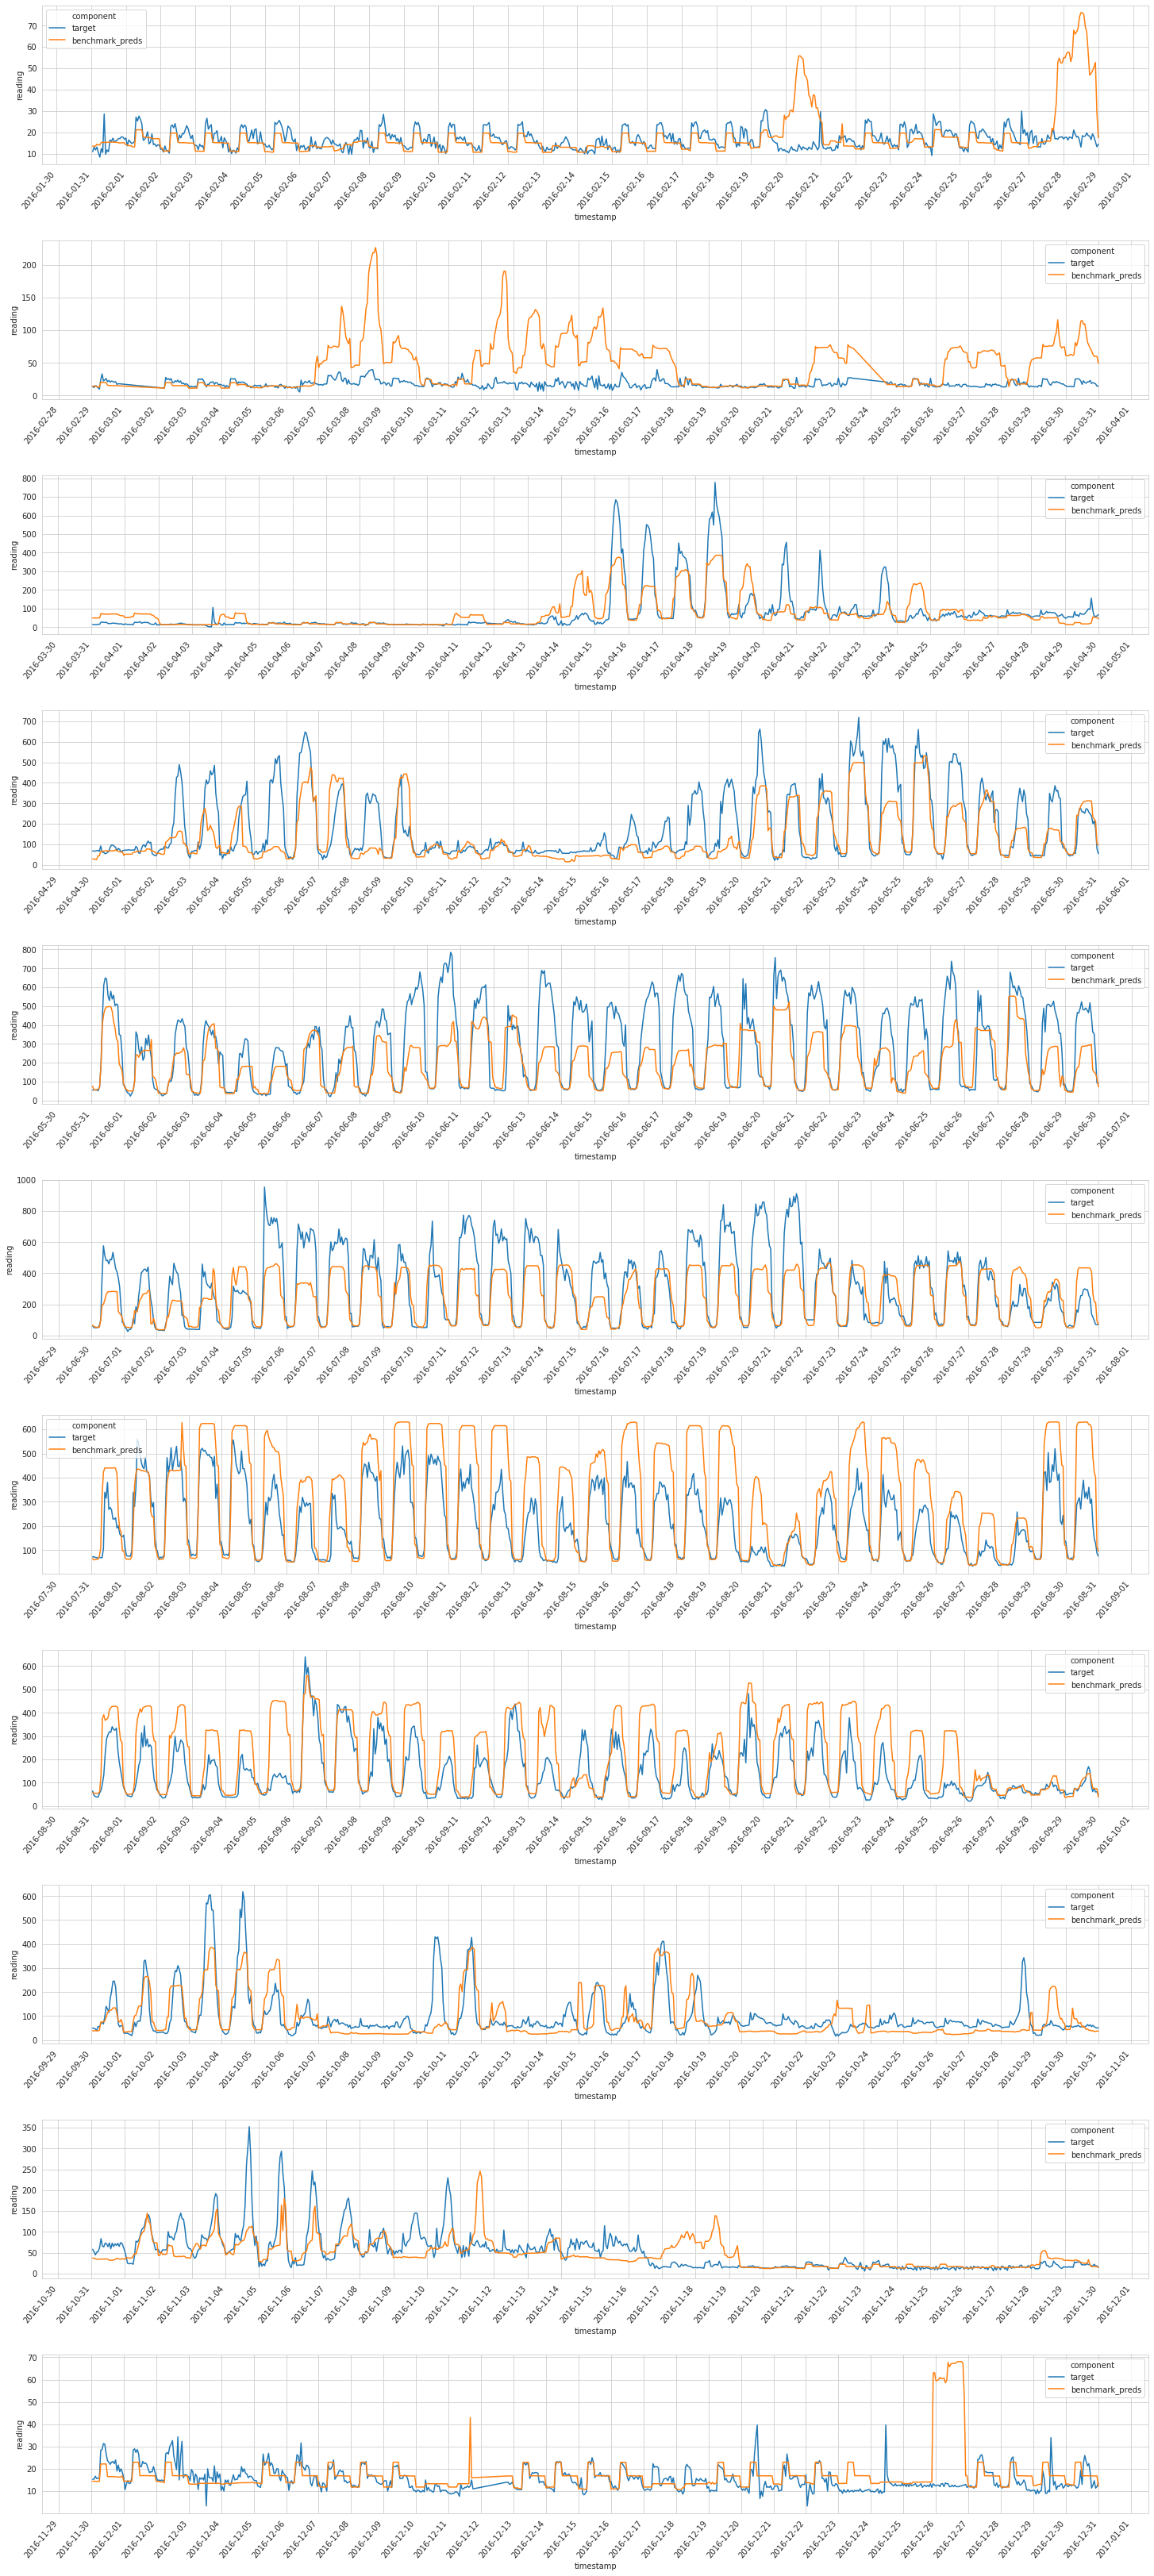

In [10]:
# Plot month by month

date_range = pd.date_range(start=X_meter.index.min()-pd.Timedelta('1 days'), 
                           end=X_meter.index.max(), freq='1M')

fig = plt.figure(figsize=(20, 4*date_range.shape[0]))

restrict_df_to_dates = lambda df, d1, d2 : df[(df['timestamp'] > d1) & (df['timestamp'] <= d2)]


with sns.axes_style("whitegrid"):
    for i in range(date_range.shape[0]-1) :
        plt.subplot(12,1,i+1)
        start_date = date_range[i]
        end_date = date_range[i+1]
        data = restrict_df_to_dates(preds_df_melt, start_date, end_date)
        ax = sns.lineplot(x="timestamp", y="reading", hue="component", data=data)
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=50, horizontalalignment='right')
plt.tight_layout(pad=0., w_pad=0., h_pad=2.)    

<b>Include precip depth</b>

In [9]:
X_meter.columns

Index(['day_of_week', 'dew_temperature_ma_24H', 'day_hour', 'dew_temperature',
       'precip_depth_1_hr_ma_4H', 'air_temperature', 'air_temperature_ma_24H',
       'precip_depth_1_hr_ma_24H'],
      dtype='object')

In [22]:
model_1_RFR = RandomForestRegressor()

pipe = make_pipeline(model_1_RFR)
pipe.get_params().keys()

rfr_grid_params = {
    'randomforestregressor__n_estimators' : [10, 25, 50, 75, 100, 125, 150, 200],
    #'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
    'randomforestregressor__max_features' : ['auto', 'sqrt'],
    #'randomforestregressor__max_depth' : [4, 6, 8, 10, 12, 20, 40]
    'randomforestregressor__max_depth' : [4, 8, 12, 20, 40]
}

rfr_CV = GridSearchCV(
    estimator=pipe, 
    param_grid=rfr_grid_params,
    scoring='neg_mean_squared_log_error',
    cv=gap_kf
)

rfr_CV.fit(X_meter, Ys_meter['meter_reading'])

print('best_params : {}'.format(rfr_CV.best_params_))
print('best_score : {}'.format(rfr_CV.best_score_))

best_params : {'randomforestregressor__max_depth': 8, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 50}
best_score : -0.34416629766199375


In [10]:
rfr_estimator=RandomForestRegressor(n_estimators=90, max_depth=7, max_features='auto')
rfr_estimator.fit(X=X_meter, y=Ys_meter['meter_reading'])
rfr_estimator.feature_importances_.tolist()

[0.0382541219616912,
 0.021790523704583942,
 0.370613766050474,
 0.003673929526441088,
 0.0003557072954437447,
 0.02200116511094291,
 0.5291002194130723,
 0.014210566937350842]

In [11]:
named_feature_importance = zip(X_meter.columns.to_list(), rfr_estimator.feature_importances_.tolist())

feature_importance_df = pd.DataFrame(named_feature_importance, columns=['feature', 'importance_score'])
feature_importance_df.set_index('feature', inplace=True)
feature_importance_df.sort_values(by='importance_score', ascending=False, inplace=True)
feature_importance_df

,importance_score
feature,
air_temperature_ma_24H,0.529100
day_hour,0.370614
day_of_week,0.038254
air_temperature,0.022001
dew_temperature_ma_24H,0.021791
precip_depth_1_hr_ma_24H,0.014211
dew_temperature,0.003674
precip_depth_1_hr_ma_4H,0.000356


Try with 'precip_depth_1_hr_ma_24H' but without 'precip_depth_1_hr_ma_4H'

In [14]:
X_meter_p24 = X_meter.copy()
X_meter_p24.drop('precip_depth_1_hr_ma_4H', axis=1, inplace=True)
X_meter_p24.columns

Index(['day_of_week', 'dew_temperature_ma_24H', 'day_hour', 'dew_temperature',
       'air_temperature', 'air_temperature_ma_24H',
       'precip_depth_1_hr_ma_24H'],
      dtype='object')

In [15]:
model_1_RFR = RandomForestRegressor()

pipe = make_pipeline(model_1_RFR)
#pipe.get_params().keys()

rfr_grid_params = {
    'randomforestregressor__n_estimators' : [10, 25, 50, 75, 100, 125, 150, 200],
    #'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
    'randomforestregressor__max_features' : ['auto', 'sqrt'],
    #'randomforestregressor__max_depth' : [4, 6, 8, 10, 12, 20, 40]
    'randomforestregressor__max_depth' : [4, 8, 12, 20, 40]
}

rfr_CV = GridSearchCV(
    estimator=pipe, 
    param_grid=rfr_grid_params,
    scoring='neg_mean_squared_log_error',
    cv=gap_kf
)

rfr_CV.fit(X_meter_p24, Ys_meter['meter_reading'])

print('best_params : {}'.format(rfr_CV.best_params_))
print('best_score : {}'.format(rfr_CV.best_score_))

best_params : {'randomforestregressor__max_depth': 8, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 100}
best_score : -0.3449922100499889


-> No improvement...